In [100]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
root_path = os.getcwd()
data_path = os.path.join(root_path, 'loan_data.csv')
data_full = pd.read_csv(data_path)

In [5]:
data = data_full[['fico_score', 'default']]

In [96]:
# Defining FICO score categories
input_label_count = 11
temp = np.linspace(300, 850, input_label_count).astype(int)

categories = {}
                         
# populating the FICO categories
for i in range(len(temp)-1):
    categories[f'F{i+1}'] = [temp[i], temp[i+1]]
    
# F1 is the best category, F10 is the worst category
categories

{'F1': [300, 355],
 'F2': [355, 410],
 'F3': [410, 465],
 'F4': [465, 520],
 'F5': [520, 575],
 'F6': [575, 630],
 'F7': [630, 685],
 'F8': [685, 740],
 'F9': [740, 795],
 'F10': [795, 850]}

In [97]:
# Function to categorize FICO scores
# Function to categorize FICO scores using dynamic programming
def categorize_fico_scores(fico_scores):
    # Create a dictionary to store the category for each score
    score_to_category = {}
    
    # Populate the dictionary with categories
    for category, (low, high) in categories.items():
        for score in range(low, high + 1):
            score_to_category[score] = category
    
    # Categorize the input FICO scores
    categorized_scores = [score_to_category[score] for score in fico_scores]
    
    return categorized_scores

In [98]:
# Categorizing FICO scores
fico_scores = data['fico_score'].to_list()

data.loc[:, 'fico_category'] = categorize_fico_scores(data['fico_score'])

<Axes: xlabel='fico_category', ylabel='Count'>

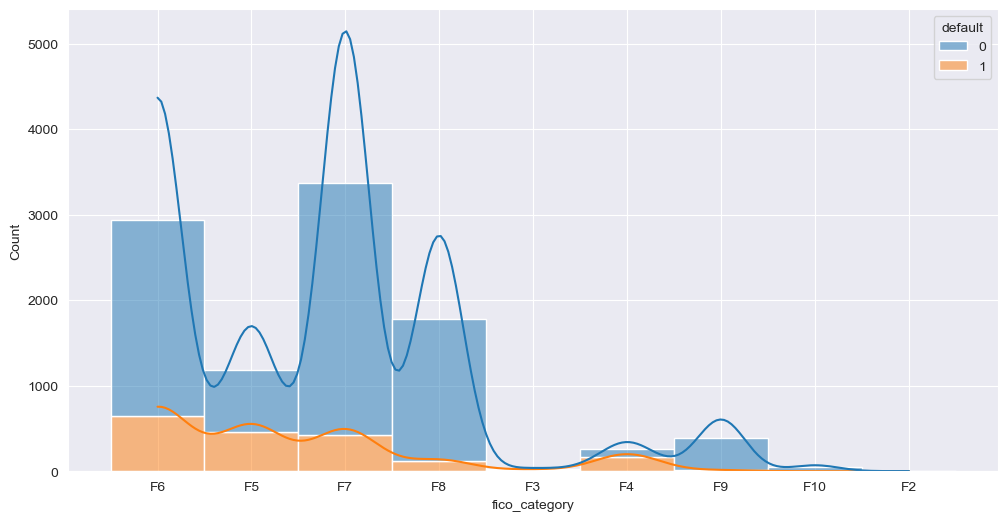

In [99]:
# Plotting the distribution of FICO score categories
plt.figure(figsize=(12, 6))
sns.histplot(data, x='fico_category', hue='default', multiple='stack', kde=True)

We have successfully created a simple categorisation of FICO scores. Let's move onto optimisation of the model, maximising log-likelihood as the objective function, using a logistic regression model. We will do a grid search to find the optimal number of buckets for the problem.

,fico_score,default,fico_category
0,605,0,F6
1,572,1,F5
2,602,0,F6
3,612,0,F6
4,631,0,F7
...,...,...,...
9995,697,0,F8
9996,615,0,F6
9997,596,0,F6
9998,647,0,F7


In [118]:
# Calculating the log-likelihood
def calculate_log_likelihood(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]  # 2nd column corresponds to the feature
    return log_loss(y, y_pred_proba, normalize=False)  # log_loss = -1 * log likelihood

# Modifying categorize_fico_scores to accept the number of buckets as an argument
def categorize_fico_scores(fico_scores, num_buckets):
    temp = np.linspace(300, 850, num_buckets + 1).astype(int)
    categories = {f'F{i+1}': (temp[i], temp[i+1]) for i in range(len(temp)-1)}
    
    score_to_category = {}
    for category, (low, high) in categories.items():
        for score in range(low, high + 1):
            score_to_category[score] = category
    
    categorized_scores = [score_to_category[score] for score in fico_scores]
    return categorized_scores

# Optimising the number of buckets
def optimize_buckets(data, target, min_buckets=2, max_buckets=20):
    best_log_likelihood = -np.inf
    best_num_buckets = min_buckets
    
    for num_buckets in range(min_buckets, max_buckets + 1):
        data.loc[:, 'fico_category'] = categorize_fico_scores(data['fico_score'], num_buckets)
        X = pd.get_dummies(data['fico_category'])
        y = data[target]
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        log_likelihood = calculate_log_likelihood(model, X_val, y_val)
        print(f'Number of buckets: {num_buckets}, Log-likelihood: {log_likelihood}')
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_num_buckets = num_buckets
    
    return best_num_buckets, best_log_likelihood

In [119]:
pd.get_dummies(data['fico_category'])

,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F4,F5,F6,F7,F8,F9
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9997,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [120]:
# Optimising the number of buckets
best_bucket_no, best_log_likelihood = optimize_buckets(data, 'default')

Number of buckets: 2, Log-likelihood: 867.3963458030873
Number of buckets: 3, Log-likelihood: 865.1460663389697
Number of buckets: 4, Log-likelihood: 849.4870573557378
Number of buckets: 5, Log-likelihood: 835.7321030509221
Number of buckets: 6, Log-likelihood: 835.0698875569534
Number of buckets: 7, Log-likelihood: 828.2622375051583
Number of buckets: 8, Log-likelihood: 827.7191229132493
Number of buckets: 9, Log-likelihood: 825.1229420195232
Number of buckets: 10, Log-likelihood: 824.0202823683132
Number of buckets: 11, Log-likelihood: 825.2307876514742
Number of buckets: 12, Log-likelihood: 823.9667816070094
Number of buckets: 13, Log-likelihood: 829.6660402991785
Number of buckets: 14, Log-likelihood: 818.7962839441211
Number of buckets: 15, Log-likelihood: 823.597612841352
Number of buckets: 16, Log-likelihood: 822.7360038669476
Number of buckets: 17, Log-likelihood: 827.5807816270708
Number of buckets: 18, Log-likelihood: 823.1799060171332
Number of buckets: 19, Log-likelihood: 8

In [121]:
print(f'Optimal number of buckets: {best_bucket_no}')
print(f'Log-likelihood for optimal number of buckets: {best_log_likelihood}')


Optimal number of buckets: 2
Log-likelihood for optimal number of buckets: 867.3963458030873


2